In [28]:
pip install xgboost


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/124.9 MB 1.3 MB/s eta 0:01:36
   ---------------------------------------- 0.4/124.9 MB 4.2 MB/s eta 0:00:30
   ---------------------------------------- 0.8/124.9 MB 5.9 MB/s eta 0:00:22
   ---------------------------------------- 1.3/124.9 MB 7.1 MB/s eta 0:00:18
    --------------------------------------- 1.9/124.9 MB 8.1 MB/s eta 0:00:16
    --------------------------------------- 2.5/124.9 MB 8.7 MB/s eta 0:00:15
    --------------------------------------- 3.0/124.9 MB 9.1 MB/s eta 0:00:14
   - -------------------------------------- 3.5/124.9 MB 9.4 MB/s eta 0:00:13
   - -------------------------------------- 4.1/124.9 MB 9.6 MB/s eta 0:00:13
   - -------------------------------------- 4.6/124.9 MB 9.8 MB/s eta 0:00:13



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
data_path = 'data/stock_technical_data/'

In [3]:
df = pd.read_csv(data_path + 'AUBANK.NS.csv', index_col=0)

In [4]:
sample_data = df['Close'].values
print(len(sample_data))

1322


In [5]:
reduced_data = sample_data[:25]

In [6]:
import numpy as np

def create_windowed_data(df, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df.iloc[i:i+window_size, :-1].values)  # Features
        y.append(df.iloc[i+window_size, -1])            # Target
    return np.array(X), np.array(y)

window_size = 30  # Adjust based on your needs
X, y = create_windowed_data(df, window_size)


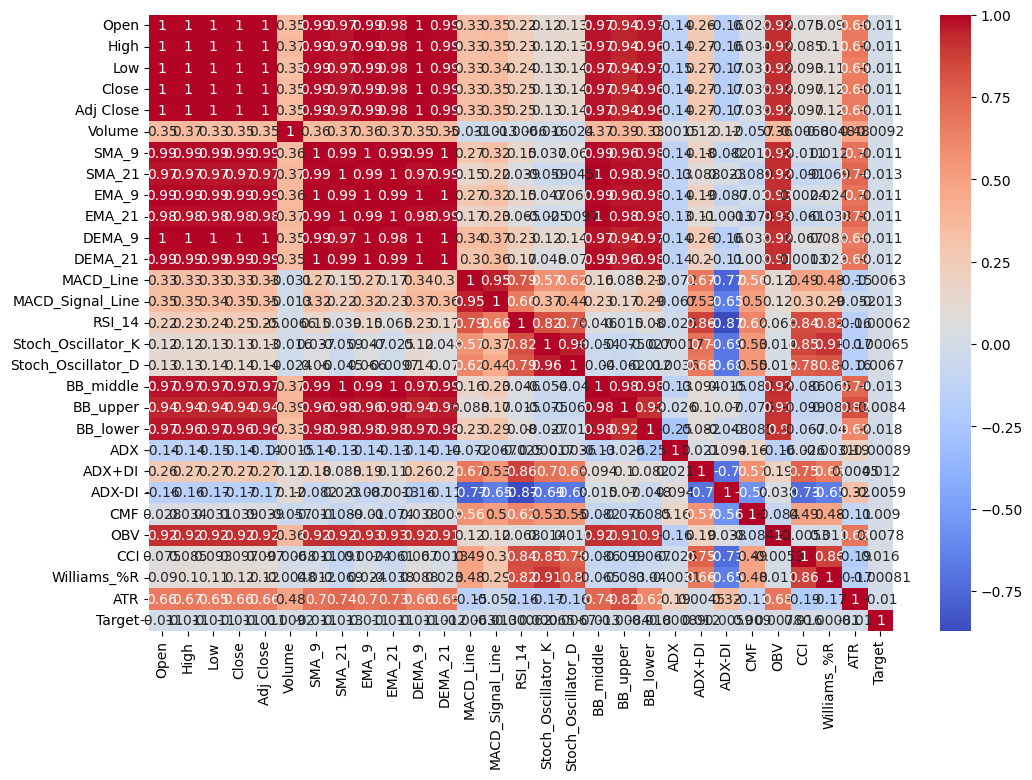

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()


In [25]:
from sklearn.model_selection import KFold
import numpy as np

def lstm_model(X_train, y_train, X_val, y_val, epochs=20):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_val, y_val))
    return model

In [26]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

lstm_predictions = []  # Store LSTM predictions for each fold

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Train LSTM on current fold
    lstm_model_instance = lstm_model(X_train, y_train, X_val, y_val)
    lstm_pred = lstm_model_instance.predict(X_val)
    
    lstm_predictions.append(lstm_pred)


Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.4734 - loss: 0.6976 - val_accuracy: 0.5019 - val_loss: 0.6928
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5020 - loss: 0.6961 - val_accuracy: 0.5135 - val_loss: 0.6925
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4790 - loss: 0.6966 - val_accuracy: 0.5097 - val_loss: 0.6919
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5619 - loss: 0.6898 - val_accuracy: 0.4788 - val_loss: 0.6928
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4804 - loss: 0.6951 - val_accuracy: 0.5097 - val_loss: 0.6918
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5520 - loss: 0.6887 - val_accuracy: 0.4981 - val_loss: 0.6948
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5196 - loss: 0.6933 - val_accuracy: 0.5097 - val_loss: 0.6925
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5402 - loss: 0.6913 - val_accuracy: 0.5135 - v

In [30]:
# Reshape X to 2D if it's 3D (e.g., flatten timesteps and features)
X_flattened = X.reshape(X.shape[0], -1)  # Flatten X from 3D to 2D

# Reshape lstm_predictions to match the number of samples (make sure it's 2D)
lstm_predictions_flat = np.concatenate(lstm_predictions).reshape(-1, 1)  # Make sure it's [samples, 1]

# Combine original features (X_flattened) with LSTM predictions
X_new = np.hstack([X_flattened, lstm_predictions_flat])  # Concatenate along the feature axis (1)


In [31]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Combine original features with LSTM predictions
lstm_predictions = np.concatenate(lstm_predictions)  # Flatten the list of predictions
X_new = np.hstack([X, lstm_predictions.reshape(-1, 1)])  # Append LSTM predictions as a new feature

# k-fold for Random Forest, XGBoost, and SVM
rf_acc, xgb_acc, svm_acc = [], [], []

for train_index, val_index in kf.split(X_new):
    X_train, X_val = X_new[train_index], X_new[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Random Forest
    rf_model = RandomForestClassifier(n_estimators=100)
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_val)
    rf_acc.append(accuracy_score(y_val, rf_pred))

    # XGBoost
    xgb_model = XGBClassifier()
    xgb_model.fit(X_train, y_train)
    xgb_pred = xgb_model.predict(X_val)
    xgb_acc.append(accuracy_score(y_val, xgb_pred))

    # SVM
    svm_model = SVC()
    svm_model.fit(X_train, y_train)
    svm_pred = svm_model.predict(X_val)
    svm_acc.append(accuracy_score(y_val, svm_pred))

print(f"Random Forest Avg Accuracy: {np.mean(rf_acc)}")
print(f"XGBoost Avg Accuracy: {np.mean(xgb_acc)}")
print(f"SVM Avg Accuracy: {np.mean(svm_acc)}")


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)